### Week 1

- calculate performance metrics of the model output compared to the truth values 

In [141]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("darkgrid")

In [142]:
df = pd.read_csv("helena_results.csv")
df.head()

,file,x1,x2,y1,y2,mask,date,start_time,frame no,quadrant,true_mask
0,park-tests/converted/coverted_FRAMES/20210526_...,720,763,185,246,0,20210526,182313,1248,3,0
1,park-tests/converted/coverted_FRAMES/20210526_...,13,40,3,40,1,20210526,182313,4876,3,1
2,park-tests/converted/coverted_FRAMES/20210526_...,695,736,201,254,0,20210526,182313,4876,3,0
3,park-tests/converted/coverted_FRAMES/20210526_...,573,663,326,430,1,20210526,182313,4397,1,1
4,park-tests/converted/coverted_FRAMES/20210526_...,893,973,346,452,1,20210526,182313,4397,1,1


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        1038 non-null   object
 1   x1          1038 non-null   int64 
 2   x2          1038 non-null   int64 
 3   y1          1038 non-null   int64 
 4   y2          1038 non-null   int64 
 5   mask        1038 non-null   int64 
 6   date        1038 non-null   int64 
 7   start_time  1038 non-null   int64 
 8   frame no    1038 non-null   int64 
 9   quadrant    1038 non-null   int64 
 10  true_mask   1038 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 89.3+ KB


#### Definitions
mask: model output

true_mask: true label (human labeled)

- 0: mask
- 1: no mask
- 2: false detection

A false detection describes an instance where the model detected the ground, or other object, as a face.

In [144]:
df['mask'].value_counts()

0    707
1    331
Name: mask, dtype: int64

In [145]:
df['true_mask'].value_counts()

1    530
0    447
2     61
Name: true_mask, dtype: int64

#### Metrics and Scoring

In [146]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# exclude false detections from this analysis
df2 = df[df['true_mask'] < 2]

df2.shape

(977, 11)

In [147]:
# store the true and predicted labels into variables for metric calculations
mask_true = df2['true_mask']
mask_pred = df2['mask']

In [148]:
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fn)

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn/(tn+fp)

def ppv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fp)

def npv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn/(fn+tn)

In [149]:
metric_functions = {'accuracy': accuracy_score, 
                    'precision': precision_score,
                    'recall': recall_score,
                    'f1': f1_score,
                    'sensitivity': sensitivity, 
                    'specificity': specificity,
                    'ppv': ppv,
                    'npv': npv}

metric_values = {}

for metric in metric_functions:
    score = metric_functions[metric](y_true=mask_true, y_pred=mask_pred)
    print(f'{metric} score: {round(score, 4)}')
    metric_values[metric] = round(score, 4)

accuracy score: 0.5988
precision score: 0.717
recall score: 0.4302
f1 score: 0.5377
sensitivity score: 0.4302
specificity score: 0.7987
ppv score: 0.717
npv score: 0.5417


### Week 2

- calculating confidence intervals around these numbers
- two sample testing of accuracy metrics - testing specificity between different groups, p values 
- looking at different groups where the metrics are better/worse
    - look for big spreads
    
- Nirmal - worked with Ted
- Ted Morris (camera / robotics, etc)
    - Camera has object detection capabilities
- Helena - worked with Catherine Zhao
    - Graduated and developed NN
    
- Catherine Zhao
    - Reach out to Catherine for training data / model code
    - Hoping to get access to the code / training data
    - Willing to put them on github with prof wolfson

#### Exploration

- explore rnn for image classification since it has a memory component and looks at multiple frames at once

#### Calculating confidence intervals around the metrics

In [150]:
def confidence_interval_z_score(n, metric):
    # standard error
    se = np.sqrt(metric * (1-metric) / n)
    
    # z score for 95% confidence interval
    z = stats.norm.ppf(0.975)
    
    lower = metric - z*se
    upper = metric + z*se
    
    return (round(lower, 4), round(upper, 4))

In [151]:
n = df.shape[0]
for metric in metric_values:
    metric_value = metric_values[metric]
    ci = confidence_interval_z_score(n, metric_value)
    print(f'95% confidence interval for the {metric} of {metric_value} is: {ci} \n')

95% confidence interval for the accuracy of 0.5988 is: (0.569, 0.6286) 

95% confidence interval for the precision of 0.717 is: (0.6896, 0.7444) 

95% confidence interval for the recall of 0.4302 is: (0.4001, 0.4603) 

95% confidence interval for the f1 of 0.5377 is: (0.5074, 0.568) 

95% confidence interval for the sensitivity of 0.4302 is: (0.4001, 0.4603) 

95% confidence interval for the specificity of 0.7987 is: (0.7743, 0.8231) 

95% confidence interval for the ppv of 0.717 is: (0.6896, 0.7444) 

95% confidence interval for the npv of 0.5417 is: (0.5114, 0.572) 



In [152]:
from sklearn.utils import resample

def confidence_interval_bootstrapping(y_true, y_pred, metric_function, n_iterations=1000, alpha=0.05):
    
    metric_samples = []
    
    for i in range(n_iterations):
        y_true_resample, y_pred_resample = resample(y_true, y_pred)
        metric_resample = metric_function(y_true_resample, y_pred_resample)
        metric_samples.append(metric_resample)
        
    lower = np.percentile(metric_samples, alpha/2*100)
    upper = np.percentile(metric_samples, (1-alpha/2)*100)
    
    return (round(lower, 4), round(upper, 4))

In [153]:
metrics_ci = {'Metric': [],
              'Score': [],
              'Lower bound': [],
              'Upper bound': [],
              'Value': []}

for metric in metric_functions:
    metrics_ci['Metric'].append(metric)
    
    metric_value = metric_values[metric]
    metrics_ci['Score'].append(metric_value)
    
    ci = confidence_interval_bootstrapping(mask_true, mask_pred, metric_functions[metric])
    metrics_ci['Lower bound'].append(ci[0])
    metrics_ci['Upper bound'].append(ci[1])
    
    metrics_ci['Value'].append([metric_value, ci[0], ci[1]])
    
    print(f'95% confidence interval for the {metric} of {metric_value} is: {ci} \n')

95% confidence interval for the accuracy of 0.5988 is: (0.568, 0.6285) 

95% confidence interval for the precision of 0.717 is: (0.6656, 0.7674) 

95% confidence interval for the recall of 0.4302 is: (0.3904, 0.4712) 

95% confidence interval for the f1 of 0.5377 is: (0.4975, 0.576) 

95% confidence interval for the sensitivity of 0.4302 is: (0.3882, 0.469) 

95% confidence interval for the specificity of 0.7987 is: (0.7596, 0.8383) 

95% confidence interval for the ppv of 0.717 is: (0.6677, 0.7681) 

95% confidence interval for the npv of 0.5417 is: (0.5067, 0.5791) 



In [154]:
metrics_df = pd.DataFrame(metrics_ci)
metrics_df

,Metric,Score,Lower bound,Upper bound,Value
0,accuracy,0.5988,0.5680,0.6285,"[0.5988, 0.568, 0.6285]"
1,precision,0.7170,0.6656,0.7674,"[0.717, 0.6656, 0.7674]"
2,recall,0.4302,0.3904,0.4712,"[0.4302, 0.3904, 0.4712]"
3,f1,0.5377,0.4975,0.5760,"[0.5377, 0.4975, 0.576]"
4,sensitivity,0.4302,0.3882,0.4690,"[0.4302, 0.3882, 0.469]"
5,specificity,0.7987,0.7596,0.8383,"[0.7987, 0.7596, 0.8383]"
6,ppv,0.7170,0.6677,0.7681,"[0.717, 0.6677, 0.7681]"
7,npv,0.5417,0.5067,0.5791,"[0.5417, 0.5067, 0.5791]"


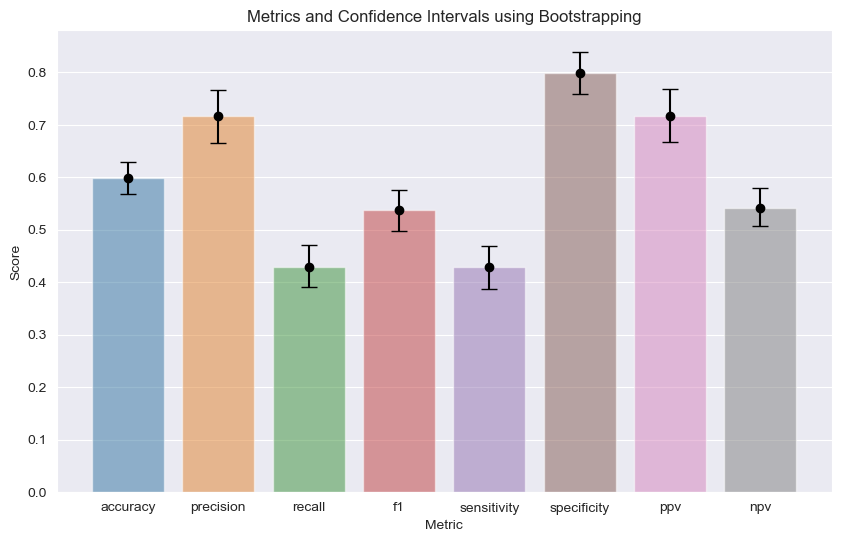

In [156]:
plt.figure(figsize=(10,6))

sns.barplot(data=metrics_df, x='Metric', y='Score', alpha=0.5)
y_error = (metrics_df['Score']-metrics_df['Lower bound'], metrics_df['Upper bound']-metrics_df['Score'])
plt.errorbar(x=metrics_df.index, y=metrics_df['Score'], yerr=y_error, fmt='o', ecolor='black', color='black', capsize=6)

plt.title("Metrics and Confidence Intervals using Bootstrapping")
plt.show()